In [16]:
import numpy as np
import scipy
import sklearn
from sklearn.decomposition import NMF
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture,BayesianGaussianMixture

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'Greys'
%matplotlib inline
import seaborn as sns

import sys,os,pdb,copy,pickle
from importlib import reload
import pynapple as nap

sys.path.append('/mnt/home/szheng/projects/seq_detection2/code')
sys.path.append('/mnt/home/szheng/projects/util_code')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis')
sys.path.append('/mnt/home/szheng/projects/nmf_analysis/scripts')
sys.path.append('/mnt/home/szheng/projects/cluster_spikes')
import data_prep_new as dpn
import place_cell_analysis as pa
import plot_helper as ph
import preprocess as prep
import nmf_analysis as na
import nmf_plot as nmfp
reload(na)

import raster_new as rn
import data_prep_pyn as dpp
import database
db = database.db

import change_point_analysis as cpa
import change_point_plot as cpp

In [2]:
data_dir_full=db.query('owner=="roman"')['data_dir_full'][0]
data_dir_full
db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)

data_dir_full  \
animal_name                                                        
e13_26m1    0  /mnt/home/szheng/ceph/ad/roman_data/e13/e13_26...   
e15_13f1    0  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            2  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
            3  /mnt/home/szheng/ceph/ad/roman_data/e15/e15_13...   
...                                                          ...   
e16_2m1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_2m...   
e16_1f1     0  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e16/e16_1f...   
e14_2m3     0  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   
            1  /mnt/home/szheng/ceph/ad/roman_data/e14/e14_2m...   

                     sess_name animal_name.1        date  \
animal_name                                                
e13_26m1    0  e13_26m1_210913      e13_26m1  2021-09-13   
e15_13f1    0  e15_13f1_220117      e15_13f1  2022-01-17   
            1  e15_13f1_220118      e15_13f1  2022-01-18   
            2  e15_13f1_220119      e15_13f1  2022-01-19   
            3  e15_13f1_220120      e15_13f1  2022-01-20   
...                        ...           ...         ...   
e16_2m1     0   e16_2m1_201116       e16_2m1  2020-11-16   
e16_1f1     0   e16_1f1_200823       e16_1f1  2020-08-23   
            1   e16_1f1_200824       e16_1f1  2020-08-24   
e14_2m3     0   e14_2m3_201017       e14_2m3  2020-10-17   
            1   e14_2m3_201019       e14_2m3  2020-10-19   

                                    behavior  performance  ntrials  \
animal_name                                                          
e13_26m1    0                    alternation     0.956522       69   
e15_13f1    0                    alternation     0.617647       34   
            1   ['alternation' 'linearMaze']     0.740741       27   
            2  ['alternation' 'alternation']     0.721311       61   
            3   ['alternation' 'linearMaze']     0.800000       45   
...                                      ...          ...      ...   
e16_2m1     0                    alternation     0.636364       11   
e16_1f1     0                    alternation     0.631579       19   
            1                    alternation     0.571429       21   
e14_2m3     0                    alternation     0.615385       26   
            1                    alternation     0.863636       22   

               ngoodtrials  n_neurons  n_pyr_putative  owner   data_root  
animal_name                                                               
e13_26m1    0           69        482             422  roman  roman_data  
e15_13f1    0           34        376             333  roman  roman_data  
            1           27        363             318  roman  roman_data  
            2           61        343             288  roman  roman_data  
            3           45        303             248  roman  roman_data  
...                    ...        ...             ...    ...         ...  
e16_2m1     0           11         50              37  roman  roman_data  
e16_1f1     0           19         47              32  roman  roman_data  
            1           21         40              27  roman  roman_data  
e14_2m3     0           26         34              26  roman  roman_data  
            1           22         36              22  roman  roman_data  

[67 rows x 12 columns]

In [3]:
# data_dir_full = '/mnt/home/szheng/ceph/ad/roman_data/e15/e15_13f1/e15_13f1_220117/'
data_dir_full = db.query('owner=="roman"').sort_values('n_pyr_putative',ascending=False)['data_dir_full'][0]

In [4]:
# load data
mat_to_return=prep.load_stuff(data_dir_full,sessionPulses = '*SessionPulses.Events.mat',filtered='*thetaFiltered*.mat')
# sessionPulses=mat_to_return['sessionPulses']
filtered = mat_to_return['filtered']
behavior=mat_to_return['behavior']

prep_res = dpp.load_spk_beh_df(data_dir_full,force_reload=False,extra_load={})
spk_beh_df=prep_res['spk_beh_df']
cell_cols_d = prep_res['cell_cols_d']
beh_df = prep_res['beh_df'].as_dataframe()
beh_df_d,beh_df=dpp.group_into_trialtype(beh_df)


load *SessionPulses.Events.mat failed


In [5]:
import nmf_one_session as nos
from itertools import product
reload(nos)
condition_df = {'do_normalize':[True,False],'speed_thresh':[0,1,5],'israte':[True,False]}
condition_df = pd.DataFrame(list(product(*condition_df.values())),columns=list(condition_df.keys()))
n_compo = 4
nmf_res_d = {}

for _,combo in condition_df.iterrows():
    do_normalize,speed_thresh,israte = combo['do_normalize'],combo['speed_thresh'],combo['israte']
    res_to_save_name = f'nmf_{n_compo}_normalize_{do_normalize}_speedthresh_{int(speed_thresh)}_rate_{israte}'
    nmf_res_d[tuple(combo.values)]=nos.nmf_one_session(data_dir_full,kwargs_={'n_compo':n_compo,'doplots':False,'n_clust':6,'do_normalize':do_normalize,'force_reload':False,'dosave':False,'speed_thresh':speed_thresh,'res_to_save_name':res_to_save_name,'israte':israte})



<module 'sys' (built-in)>
<module 'sys' (built-in)>
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_0_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_1_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_True.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_26m1/e13_26m1_210913/py_data/nmf/nmf_4_normalize_True_speedthresh_5_rate_False.p already exists! Loading--
/mnt/home/szheng/ceph/ad/roman_data/e13/e13_2

In [6]:
nmf_res_d[(False,1,True)].keys()

dict_keys(['W_df_peaks_only_post_sorted_d', 'X_normed_restacked_df_d', 'kwargs', 'W_sorted_d', 'H_sorted_d', 'W_df_peaks_only_d', 'W_df_original_d'])

In [7]:
X_restacked_df_d=nmf_res_d[(False,1,True)]['X_normed_restacked_df_d']
W_df_peaks_only_d=nmf_res_d[(False,1,True)]['W_df_peaks_only_d']

key=(0,0)
X_peaks = X_restacked_df_d[key].loc[W_df_peaks_only_d[key].index]
sigma=1
X_peaks_smth = scipy.ndimage.gaussian_filter1d(X_peaks,sigma,axis=1)
X_peaks_smth = pd.DataFrame(X_peaks_smth,index=X_peaks.index,columns=X_peaks.columns)

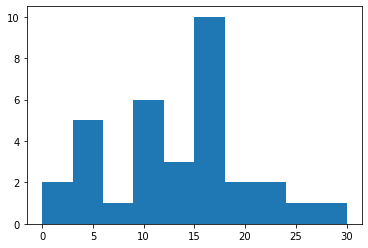

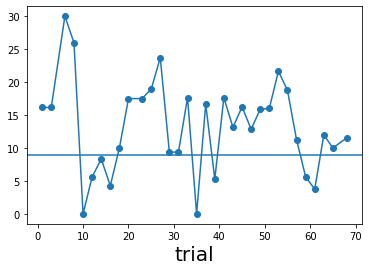

In [12]:
%matplotlib inline
uid,pos=2,1
uid, pos = X_peaks.index[4]
x=X_peaks.loc[uid,pos]
plt.hist(x)
plt.figure()
X_peaks.loc[uid,pos].plot(marker='o')

# z_x = scipy.stats.zscore(x)
thresh_ratio = 0.3
thresh = thresh_ratio * np.max(x)
plt.axhline(thresh)


<AxesSubplot:xlabel='trial'>

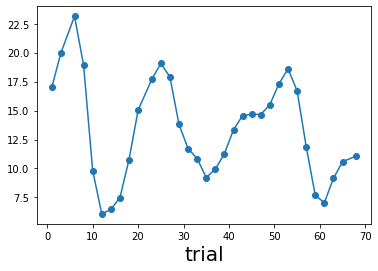

In [84]:

X_peaks_smth.loc[uid,pos].plot(marker='o')

In [20]:
# signal=scipy.stats.zscore(X_peaks.loc[uid,pos])
signal=scipy.stats.zscore(X_peaks_smth.loc[uid,pos])
cpa.get_change_points_one_field(signal,pen=0.1,trial_index=X_peaks.columns)

Float64Index([8.0, 12.0, 18.0, 23.0, 29.0, 33.0, 41.0, 45.0, 49.0, 55.0], dtype='float64', name='trial')

In [58]:
thresh_ratio = 0.3
min_fr_thresh  = 1.

onoff_df,changes_df, cross_pts_df = cpa.detect_switch_simple(X_peaks, thresh_ratio=thresh_ratio, min_fr_thresh=min_fr_thresh)
# onoff_df,changes_df, cross_pts_df = cpa.detect_switch_simple(X_peaks_smth, thresh_ratio=thresh_ratio, min_fr_thresh=min_fr_thresh)


<AxesSubplot:xlabel='trial', ylabel='None-lin_binned'>

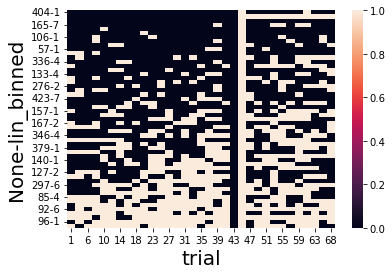

In [45]:
%matplotlib inline
trial_ind=21
allfields_on_one_trial = onoff_df.loc[(changes_df==1).iloc[:,trial_ind]]
sorted_index=allfields_on_one_trial.iloc[:,:trial_ind].sum(axis=1).sort_values().index
sns.heatmap(allfields_on_one_trial.loc[sorted_index])

# on off detection

In [88]:
thresh_ratio = 0.3
min_fr_thresh  = 1.
# onoff_df,changes_df, cross_pts_df = cpa.detect_switch_simple(X_peaks, thresh_ratio=thresh_ratio, min_fr_thresh=min_fr_thresh)
onoff_df,changes_df, cross_pts_df = cpa.detect_switch_simple(X_peaks_smth, thresh_ratio=thresh_ratio, min_fr_thresh=min_fr_thresh)
transition_p_all=cpa.get_transition_p_population(onoff_df)
sw = cpa.get_switch_ratio_per_trial(changes_df,True)

(array([   891.,   1009.,   3120.,   6592.,   7931.,  20448.,  20568.,
         32250.,  48141., 158975.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

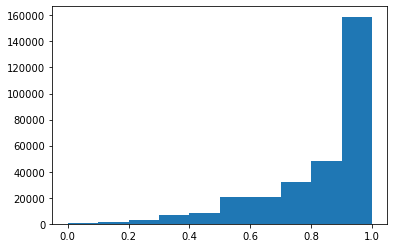

In [479]:
from scipy.spatial.distance import pdist,squareform,dice


In [789]:
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [822]:
%time res=cpa.get_sig_pairs(onoff_df,X_sim_l)

CPU times: user 23.6 s, sys: 2.02 s, total: 25.6 s
Wall time: 25.6 s


In [791]:
X_fake = X_sim_l[0]

In [820]:
import tqdm
nrepeats=200
X_sim_l = []
sr_l = []
nfields,ntrials = X_peaks.shape
x_init = onoff_df.iloc[:,0]
for i in tqdm.tqdm(range(nrepeats)):
#     x_init = (np.random.rand(nfields) < (onoff_df==1).mean(axis=1)).astype(int)
    X_sim = gen_switching_data(transition_p_all,x_init,ntrials=ntrials)
    X_sim_l.append(X_sim)
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim, thresh_ratio=0, min_fr_thresh=0.001)
    switch_ratio = cpa.get_switch_ratio_per_trial(changes_df_sim,skip_last_col=True)
    sr_l.append(switch_ratio)
res_fake=cpa.get_sig_pairs(X_fake,X_sim_l)

100%|██████████| 200/200 [00:07<00:00, 28.53it/s]
/mnt/home/szheng/ceph/envs/jax/lib/python3.9/site-packages/scipy/spatial/distance.py:1424: RuntimeWarning: invalid value encountered in true_divide
  return float((ntf + nft) / np.array(2.0 * ntt + ntf + nft))
/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py:159: RuntimeWarning: invalid value encountered in true_divide


In [823]:
res['sig'].mean()

0.037272651496207385

In [821]:
res_fake['sig'].mean()

0.04916229057264316

In [798]:
sig_ilocs = res_fake['sig_ilocs']

In [816]:
ii = 400
iloc1=sig_ilocs[0][ii]
iloc2=sig_ilocs[1][ii]
# dist_sim_onepair=[dice(X_sim_l[rr].iloc[iloc1],X_sim_l[rr].iloc[iloc2]) for rr in range(len(X_sim_l))]

In [817]:
all_dists_sim.shape

(50, 299925)

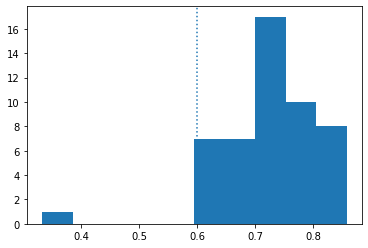

In [818]:
all_dists_sim_sq = res_fake['all_dists_sim_sq']
plt.hist(all_dists_sim_sq[:,iloc1,iloc2])
# plt.axvline(dist_sq[iloc1,iloc2])
sig_thresh = res_fake['sig_thresh']
plt.axvline(squareform(sig_thresh)[iloc1,iloc2],linestyle=':')

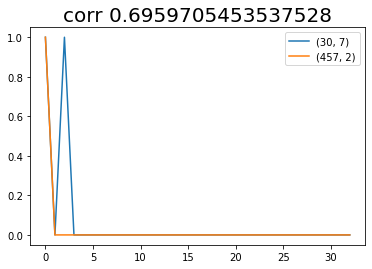

In [819]:
X_fake.iloc[iloc1].plot()
X_fake.iloc[iloc2].plot()
corr = X_fake.T.corr().iloc[iloc1,iloc2]
plt.title(f'corr {corr}')
plt.legend()

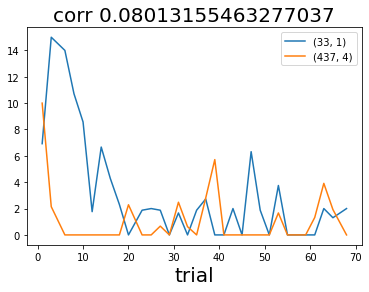

In [803]:
X_peaks.iloc[iloc1].plot()
X_peaks.iloc[iloc2].plot()
corr = X_peaks.T.corr().iloc[iloc1,iloc2]
plt.title(f'corr {corr}')
plt.legend()

(array([  1025.,   1139.,   2840.,   6117.,   7468.,  18314.,  20197.,
         30335.,  43981., 165506.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

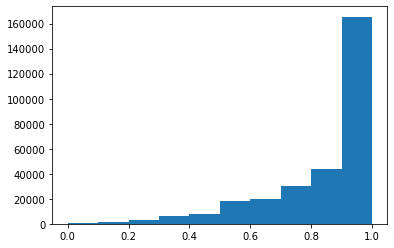

In [478]:
dist = pdist(onoff_df_sim,metric=dice)
dist_sq=squareform(dist)
plt.hist(dist)

In [244]:
transition_p_all.values.mean()

,0,1
0,0.800672,0.199328
1,0.719873,0.280127


In [89]:
import tqdm
nrepeats=200
X_sim_l = []
sr_l = []
nfields,ntrials = X_peaks.shape
x_init = onoff_df.iloc[:,0]
for i in tqdm.tqdm(range(nrepeats)):
#     x_init = (np.random.rand(nfields) < (onoff_df==1).mean(axis=1)).astype(int)
    X_sim = cpa.gen_switching_data(transition_p_all,x_init,ntrials=ntrials)
    X_sim_l.append(X_sim)
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim, thresh_ratio=0, min_fr_thresh=0.001)
    switch_ratio = cpa.get_switch_ratio_per_trial(changes_df_sim,skip_last_col=True)
    sr_l.append(switch_ratio)

100%|██████████| 200/200 [00:06<00:00, 30.11it/s]


In [422]:
X_sim.columns = X_peaks.columns

In [423]:
reload(cpp)
reload(cpa)

<module 'change_point_analysis' from '/mnt/home/szheng/projects/nmf_analysis/change_point_analysis.py'>

In [424]:
# onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim, thresh_ratio=0, min_fr_thresh=0.001)



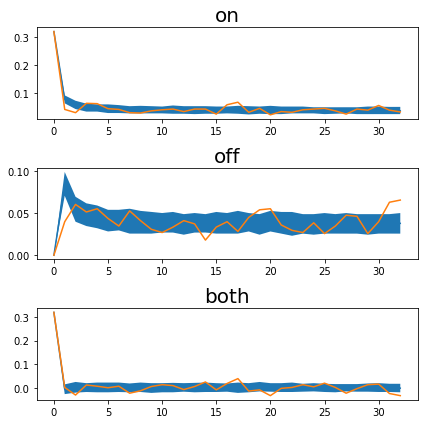

In [90]:
fig,axs=plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    sr_on=pd.DataFrame([sr[k] for sr in sr_l]).T
    # sr_on.plot()

    alpha=0.05
    yerr=pd.DataFrame([sr_on.quantile(1-alpha/2,axis=1),sr_on.quantile(alpha/2,axis=1)])
    # yerr = yerr - np.mean(sr_on.values,axis=1,keepdims=True).T

    sr_on_mean = sr_on.mean(axis=1)
    sr_on_mean.plot(ax=axs[ii])
    axs[ii].fill_between(sr_on_mean.index,yerr.iloc[0],yerr.iloc[1])
    axs[ii].plot(sw[k].values)
    axs[ii].set_title(k)
plt.tight_layout()

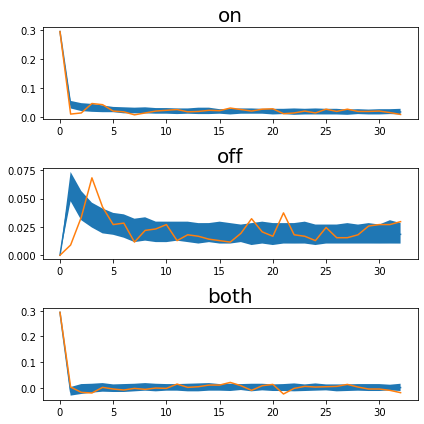

In [74]:
fig,axs=plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    sr_on=pd.DataFrame([sr[k] for sr in sr_l]).T
    # sr_on.plot()

    alpha=0.05
    yerr=pd.DataFrame([sr_on.quantile(1-alpha/2,axis=1),sr_on.quantile(alpha/2,axis=1)])
    # yerr = yerr - np.mean(sr_on.values,axis=1,keepdims=True).T

    sr_on_mean = sr_on.mean(axis=1)
    sr_on_mean.plot(ax=axs[ii])
    axs[ii].fill_between(sr_on_mean.index,yerr.iloc[0],yerr.iloc[1])
    axs[ii].plot(sw[k].values)
    axs[ii].set_title(k)
plt.tight_layout()

In [212]:
onoff_df

trial           1   3   6   8   10  12  14  16  18  20  ...  49  51  53  55  \
    lin_binned                                          ...                   
1   7            0   0   1   0   0   0   0   0   0   0  ...   0   0   0   0   
3   3            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
27  1            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
    7            0   1   0   0   0   0   0   0   1   0  ...   0   1   0   0   
29  2            0   0   1   1   0   0   0   0   0   0  ...   0   0   0   0   
...             ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...  ..  ..  ..  ..   
478 1            0   0   0   0   0   0   0   0   0   0  ...   0   0   1   0   
    4            0   0   0   0   0   0   0   0   1   0  ...   0   0   0   0   
479 6            0   0   0   0   0   0   1   0   0   0  ...   0   0   0   0   
480 3            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   
    8            0   0   0   0   0   0   0   0   0   0  ...   0   0   0   0   

trial           57  59  61  63  65  68  
    lin_binned                          
1   7            0   0   0   0   0   0  
3   3            0   0   0   0   0   0  
27  1            0   0   1   0   0   0  
    7            0   0   0   0   0   0  
29  2            0   0   0   0   0   0  
...             ..  ..  ..  ..  ..  ..  
478 1            0   0   0   0   0   0  
    4            0   0   0   0   0   0  
479 6            0   0   0   0   0   0  
480 3            0   0   0   0   0   0  
    8            0   0   1   0   0   0  

[775 rows x 33 columns]

In [419]:
W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(onoff_df.values,4)
err = np.linalg.norm(X_sorted- X_recon_sorted,'fro')**2 /np.linalg.norm(X_recon_sorted,'fro')**2

Text(0.5, 1.0, '0.6874990582950318')

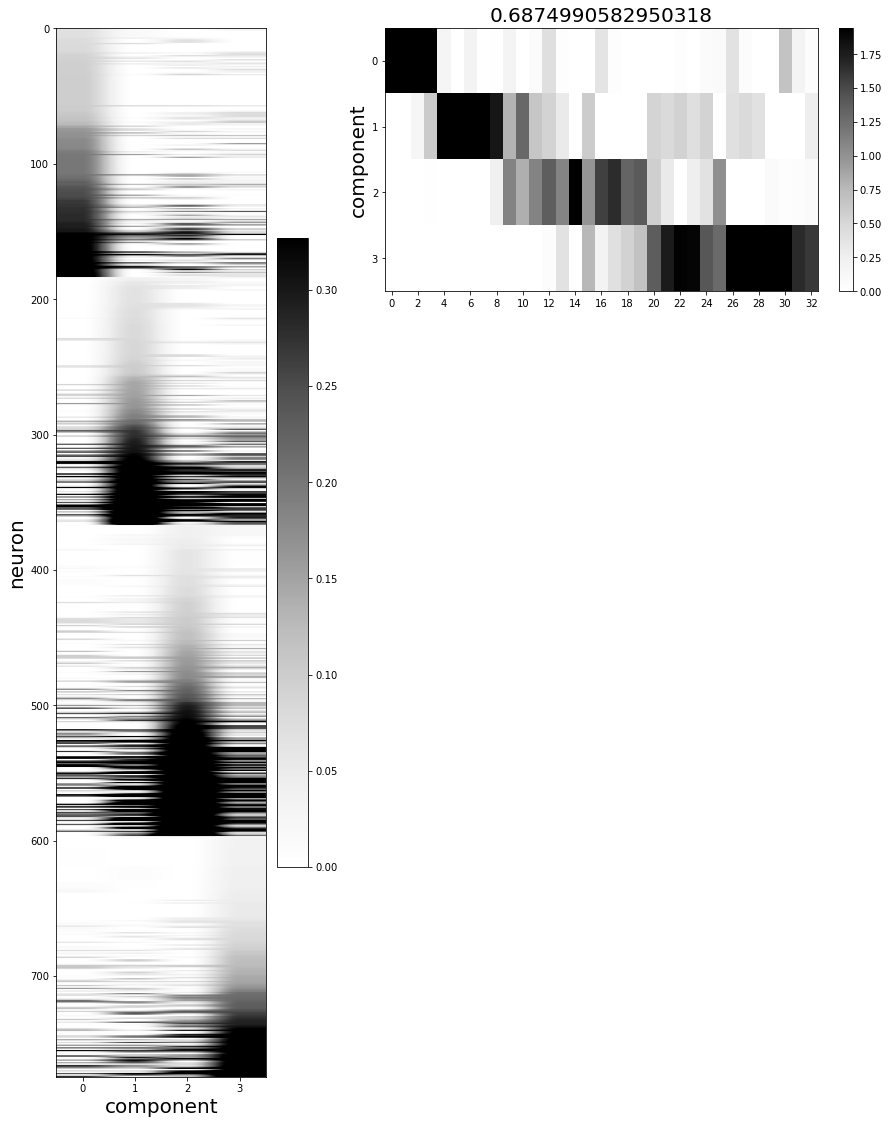

In [420]:
fig,axs=nmfp.plot_wh(W_sorted,H_sorted)
axs['H'].set_title(err)

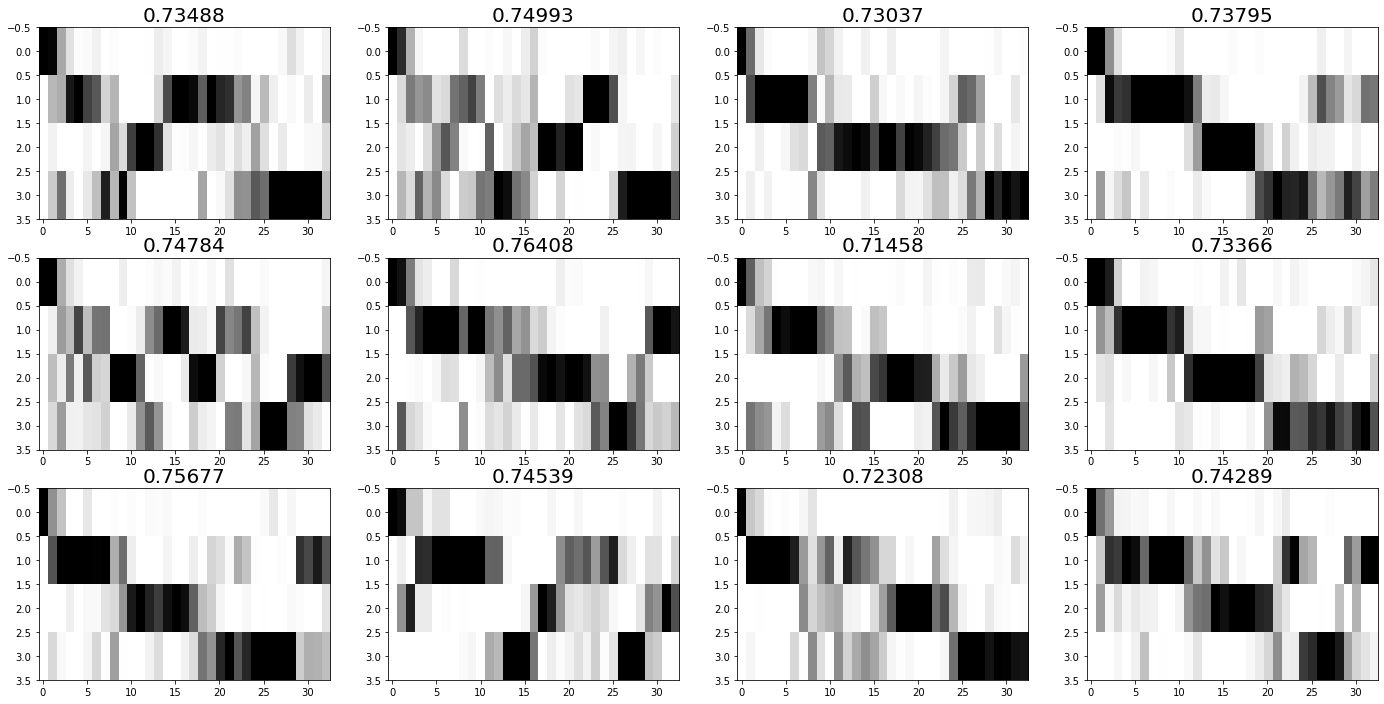

In [426]:
nplots=12
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii in range(nplots):
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim_l[ii], thresh_ratio=0, min_fr_thresh=0.001)
    W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(onoff_df_sim.values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    axs.ravel()[ii].set_title(f'{err_ratio:.05f}')
    
    

In [252]:
onoff_df.mean(axis=1)

     lin_binned
1    7             0.030303
3    3             0.545455
27   1             0.939394
     7             0.969697
29   2             0.757576
                     ...   
478  1             0.030303
     4             0.030303
479  6             0.121212
480  3             0.090909
     8             0.545455
Length: 775, dtype: float64

# simple null, no transition, assuming independence in trials

In [67]:

p_on = onoff_df.mean(axis=1)
onoff_sim_l = (np.random.rand(nrepeats,nfields,ntrials)<p_on.values[None,:,None]).astype(int)
sr_l= []
X_sim_l=[]
for n in range(nrepeats):
    X_sim = pd.DataFrame(onoff_sim_l[n])
    X_sim_l.append(X_sim)
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim, thresh_ratio=0, min_fr_thresh=0.001)
    switch_ratio = cpa.get_switch_ratio_per_trial(changes_df_sim,skip_last_col=True)
    sr_l.append(switch_ratio)


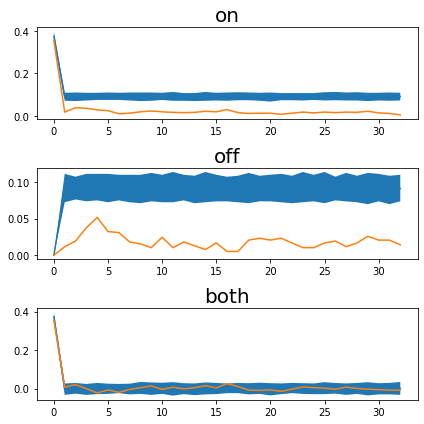

In [68]:
fig,axs=plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    sr_on=pd.DataFrame([sr[k] for sr in sr_l]).T
    # sr_on.plot()

    alpha=0.05
    yerr=pd.DataFrame([sr_on.quantile(1-alpha/2,axis=1),sr_on.quantile(alpha/2,axis=1)])
    # yerr = yerr - np.mean(sr_on.values,axis=1,keepdims=True).T

    sr_on_mean = sr_on.mean(axis=1)
    sr_on_mean.plot(ax=axs[ii])
    axs[ii].fill_between(sr_on_mean.index,yerr.iloc[0],yerr.iloc[1])
    axs[ii].plot(sw[k].values)
    axs[ii].set_title(k)
plt.tight_layout()

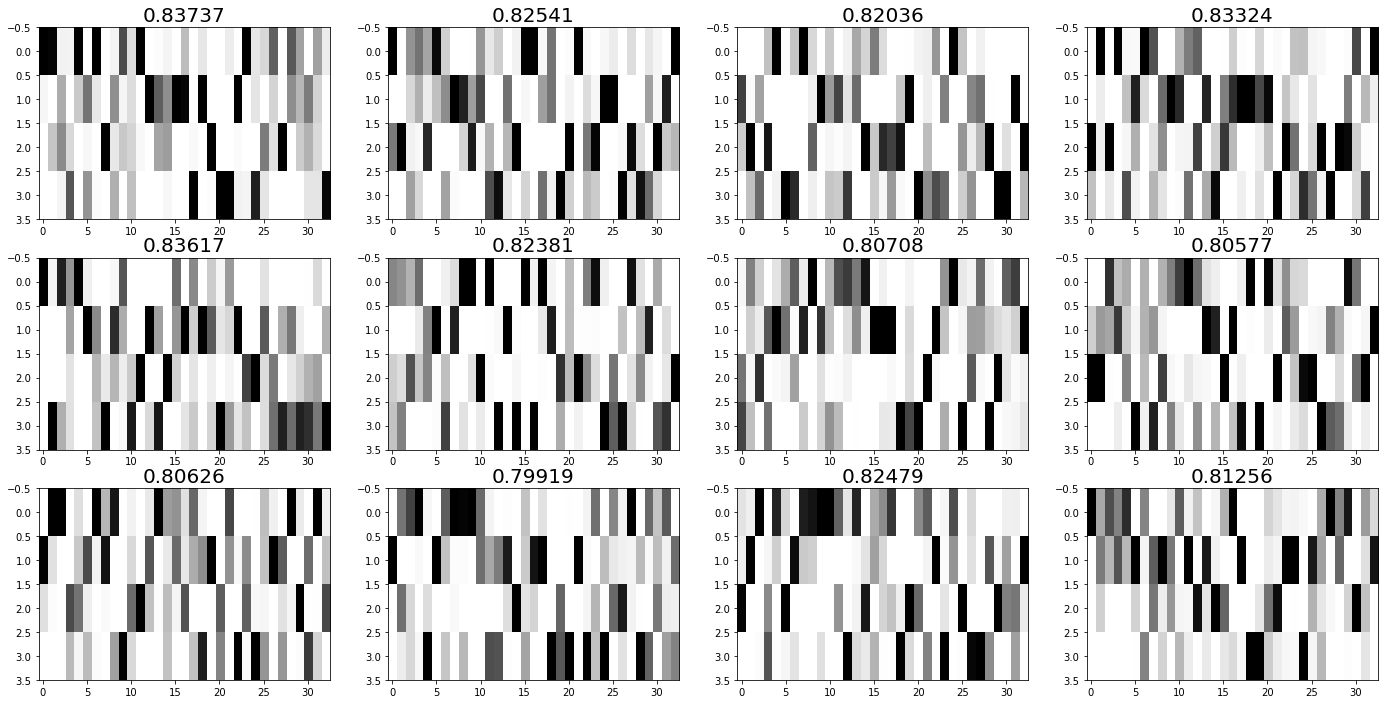

In [418]:
nplots=12
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii in range(nplots):
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim_l[ii], thresh_ratio=0, min_fr_thresh=0.001)
    W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(onoff_df_sim.values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    axs.ravel()[ii].set_title(f'{err_ratio:.05f}')
    
    

# null model: circular shuffle of the rows

In [75]:

X=onoff_df.values
nfields,ntrials=X.shape
nrepeats=200
X_all_roll = np.array([np.roll(X,i,axis=1) for i in range(X.shape[1])])

new_start_inds=np.random.randint(ntrials-1,size=(nrepeats,nfields))

onoff_sim_l=np.array([X_all_roll[new_start_inds[i],np.arange(nfields)] for i in range(new_start_inds.shape[0])])
X_sim_l=[]
sr_l=[]
for n in range(nrepeats):
    X_sim = pd.DataFrame(onoff_sim_l[n])
    X_sim_l.append(X_sim)
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim, thresh_ratio=0, min_fr_thresh=0.001)
    switch_ratio = cpa.get_switch_ratio_per_trial(changes_df_sim,skip_last_col=True)
    sr_l.append(switch_ratio)


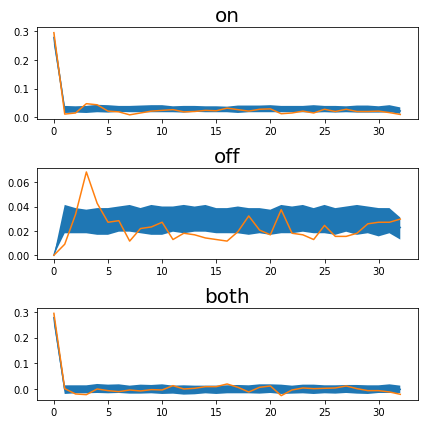

In [76]:
fig,axs=plt.subplots(3,1,figsize=(6,6))
for ii,k in enumerate(['on','off','both']):
    sr_on=pd.DataFrame([sr[k] for sr in sr_l]).T
    # sr_on.plot()

    alpha=0.05
    yerr=pd.DataFrame([sr_on.quantile(1-alpha/2,axis=1),sr_on.quantile(alpha/2,axis=1)])
    # yerr = yerr - np.mean(sr_on.values,axis=1,keepdims=True).T

    sr_on_mean = sr_on.mean(axis=1)
    sr_on_mean.plot(ax=axs[ii])
    axs[ii].fill_between(sr_on_mean.index,yerr.iloc[0],yerr.iloc[1])
    axs[ii].plot(sw[k].values)
    axs[ii].set_title(k)
#     axs[ii].set_ylim([-0.03,0.05])
plt.tight_layout()

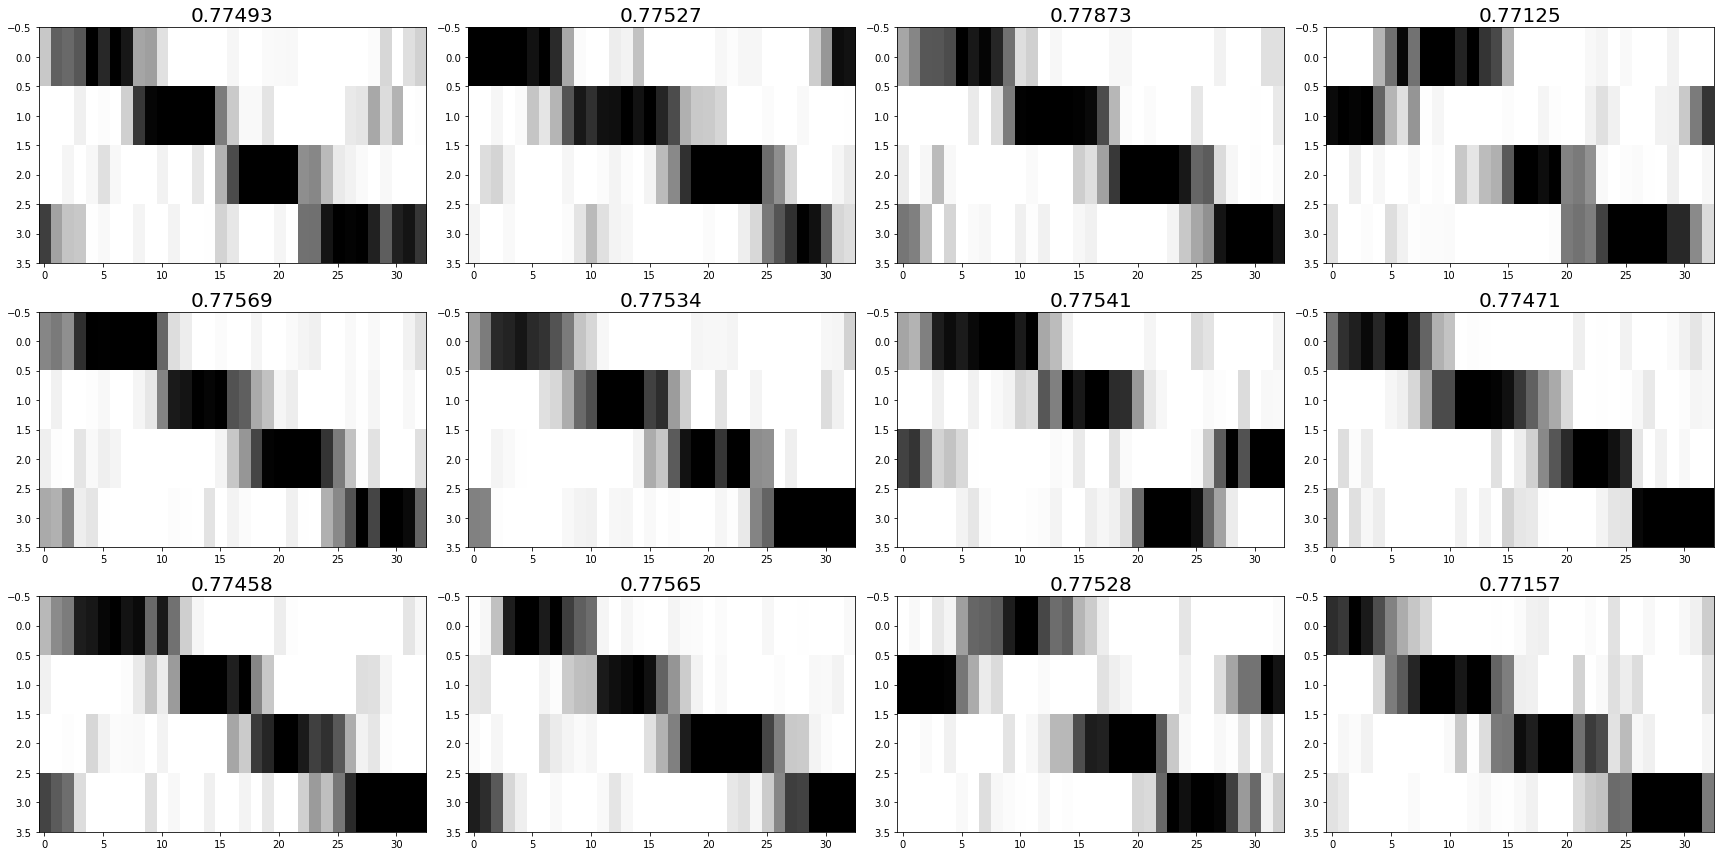

In [415]:
nplots=12
fig,axs=ph.subplots_wrapper(nplots,return_axs=True)
for ii in range(nplots):
    onoff_df_sim,changes_df_sim, cross_pts_df_sim = cpa.detect_switch_simple(X_sim_l[ii], thresh_ratio=0, min_fr_thresh=0.001)
    W, W_sorted,W_inds, factor_assignment, H_sorted, X_sorted, X_recon_sorted=na.nmf_and_sort(onoff_df_sim.values,4)
    # nmfp.plot_wh(W_sorted,H_sorted)
    err_ratio=np.linalg.norm(X_sorted - X_recon_sorted,'fro')**2 / np.linalg.norm(X_recon_sorted,'fro')**2
    axs.ravel()[ii].imshow(H_sorted,aspect='auto',vmax=np.quantile(H_sorted,0.9))
    axs.ravel()[ii].set_title(f'{err_ratio:.05f}')
plt.tight_layout()
    

In [448]:
(changes_df.iloc[:,:-1]==1).mean(axis=1).mean()

0.11100684261974585

In [446]:
(changes_df.iloc[:,:-1]==-1).mean(axis=1).mean()

0.10482893450635385

In [431]:
scipy.stats.binom.ppf(0.975,nfields,0.1)

94.0

In [436]:
xticks = np.arange(10,100)

In [437]:
xticks

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94,
       95, 96, 97, 98, 99])

In [444]:
np.arange(1,100,10)

array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])

([<matplotlib.axis.XTick at 0x1554731adca0>,
 [Text(0, 0, '0.0'),
  Text(20, 0, '0.03'),
  Text(40, 0, '0.05'),
  Text(60, 0, '0.08'),
  Text(80, 0, '0.1')])

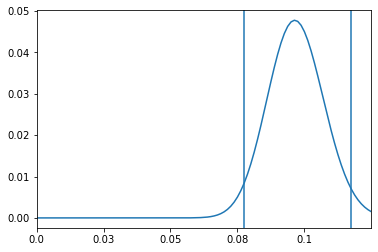

In [445]:
xs=np.arange(0,nfields)
pmfs = scipy.stats.binom.pmf(xs,nfields,0.1)
high =scipy.stats.binom.ppf(0.975,nfields,0.1)
low = scipy.stats.binom.ppf(0.025,nfields,0.1)

plt.plot(pmfs)
plt.axvline(low)
plt.axvline(high)
plt.xlim(0,100)
xticks = np.arange(0,100,20)
xtickslabels = np.round(xticks / nfields,2)
plt.xticks(xticks,xtickslabels)


In [392]:
mean_trans_p=transition_p_all.values.mean()

In [396]:
p = mean_trans_p.loc[0,0]
q = mean_trans_p.loc[1,1]
(1-q)/(2-p-q)

0.7831504825337232

In [399]:
(onoff_df_sim==1).mean().mean()

0.23006842619745846

In [403]:
(onoff_df==1).mean().mean()

0.232297165200391

In [ ]:
t = np.array([0.2,0.8;])